# PREDIÇÃO PARA CASOS CONFIRMADOS DE COVID

#### IMPORTAÇÕES

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import math
from IPython.display import display, Markdown, Image
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from scipy.stats import pearsonr

import random
import warnings

from pickle import dump

# IMPORT REDES NEURAIS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
import sklearn
sklearn.__version__

'0.23.1'

In [3]:
tf.__version__

'2.1.0'

#### FUNÇÕES

### Função para cálculo do Fator de 2

In [4]:
def get_fac2(y_true, y_pred):
    min_ = 0.5
    max_ = 2
    
    eps = np.finfo(np.float).eps
    
    division = y_pred / (y_true+eps)
    
    greater_min = np.greater_equal(division, min_)
    less_max = np.less_equal(division, max_)

    res = np.equal(greater_min, less_max)
    res = res.astype(float)

    fac_2 = res.mean()

    return fac_2

In [5]:
def plot_samples(y_true, y_pred, title='', xlabel='', ylabel='', filename="LSTMCNN"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        days = list(range(col+1, (col+1)+len(y_true)))
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.plot(days, y_true.iloc[:, col], label='Real')
        plt.plot(days, y_pred.iloc[:, col], label='Previsão')
        plt.legend()
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)
        plt.xlim(left=days[0], right=days[-1])
        plt.xticks(np.linspace(days[0], days[-1], num=5, dtype=int))
    plt.tight_layout()    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename +"_plot_samples.png", dpi=600)
    plt.show()
    
def plot_scatter(y_true, y_pred, title='', filename="LSTMCNN"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        max_val = max(y_true.iloc[:, col].max(), y_pred.iloc[:, col].max())
        min_val = min(y_true.iloc[:, col].min(), y_pred.iloc[:, col].min())
                
        max_lim = max_val + max_val*0.05
        max_lim = math.ceil(max_lim)
        
        ndigits = len(str(max_lim))
        max_lim = int(math.ceil(max_lim / (10.0**(ndigits-2)) )) * (10.0**(ndigits-2))
        
        min_lim = min_val - max_val*0.05
        min_lim = max(0, min_lim)
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.scatter(y_true.iloc[:, col], y_pred.iloc[:, col])
        plt.xlabel('Real', fontsize=10)
        plt.ylabel('Previsão', fontsize=10)
        
        plt.xlim(left=min_lim, right=max_lim)
        plt.ylim(top=max_lim, bottom=min_lim)
        
        plt.xticks(np.linspace(min_lim, max_lim, num=5, dtype=int))
        plt.yticks(np.linspace(min_lim, max_lim, num=5, dtype=int))

        plt.plot([min_lim, max_lim], [min_lim, max_lim])
   
    plt.tight_layout()       
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename + "_plot_scatter.png", dpi=600)
    plt.show()
    
def get_metrics(y_true, y_pred, filename="LSTMCNN"):
    
    metrics = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'Pearson r', 'Fac2'])
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        y_true_col = y_true.iloc[:, col]
        y_pred_col = y_pred.iloc[:, col]

        if y_true_col.name == y_pred_col.name:
            col_name = y_true_col.name
        else:
            print('Column name error.')
            return None

        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = mean_squared_error(y_true_col, y_pred_col, squared=False)
        mae = mean_absolute_error(y_true_col, y_pred_col)
        pearson_r = pearsonr(y_true_col, y_pred_col)[0]
        fac2 = get_fac2(y_true_col.values, y_pred_col.values)
        metrics.loc[col_name, :] = [mse, rmse, mae, pearson_r, fac2]

    metrics.loc['Average', :] = metrics.mean()
#     metrics.to_csv("csv_metrics/" + filename + "_Metricas.csv",index=False)
    return metrics

def plot_metrics(dict_metrics, title='', xlabel='', ylabel='', filename="LSTM"):
    
    plt.figure(figsize=(14, 12))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    keys = list(dict_metrics.keys())
    key_0 = keys[0]
    metrics_df_0 = dict_metrics[key_0]
    metrics_names = metrics_df_0.columns
    time_steps = list(range(1, metrics_df_0.shape[0]))
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        
        for key in dict_metrics.keys():
            
            metrics_df = dict_metrics[key]
            plt.plot(time_steps, metrics_df.iloc[0:-1, col], marker='o', label=key)
        
        plt.title('{} para cada horizonte de previsão'.format(metric_name))
        plt.legend()
        plt.xlabel('Dias a frente', fontsize=10)
        plt.ylabel(metric_name, fontsize=10)
        plt.xlim(left=time_steps[0], right=time_steps[-1])
        plt.xticks(np.linspace(time_steps[0], time_steps[-1], num=5, dtype=int))
        
        
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
#     plt.savefig(filename + "_plot_scatter.png", dpi=600)
    plt.show()

In [6]:
def generate_single_region_dataset(key, region_data, look_back, look_forward, x_columns, y_columns=None, gen_x=True, gen_y=True):
    
    # Check region dataframe
    if region_data is None:
        print('generate_single_region_dataset error: Region data is None!')
        return (None, None)
    
    # Check number of regions
    if len(region_data[key].unique()) > 1:
        print('generate_single_region_dataset error: More than one region in the dataframe!')
        return (None, None)
    else:
        region_name = region_data[key].unique()[0]
    
    # Drop 'Region' column
    region_data = region_data.drop(columns=key)
    
    # Check the number of samples available to
    # generate the look back and look forward windows
    if len(region_data) < (look_back + look_forward):
        print('generate_single_region_dataset error: Not enough samples '+
              'in {} to generate the windows!'.format(region_name))
        return (None, None)
    
    n_samples = len(region_data) - look_back - look_forward + 1

    var_names = x_columns
    
    # Generate inputs
    if gen_x:
        inputs = pd.DataFrame()
        
        for i in range(n_samples):
            input_window = region_data.T.iloc[:, i:i+look_back]
            wide_input_sample = pd.DataFrame()
            
            for var in var_names:
                var_input_sample = input_window.loc[var:var, :]
                var_input_sample.columns = ['{}_t{}'.format(var, a) for a in range(1-look_back, 1)]
                var_input_sample = var_input_sample.reset_index(drop=True)
                wide_input_sample = pd.concat([wide_input_sample, var_input_sample], axis='columns')
                
            inputs = pd.concat([inputs, wide_input_sample], axis='index')
            
        # Insert region name
        #inputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        inputs = inputs.reset_index(drop=True)

    # Generate outputs
    if gen_y:
        
        if y_columns is None:
            print('generate_single_region_dataset error: Need to specify column labels!')
            return (None, None)
        
        var_names = y_columns
        outputs = pd.DataFrame()
        
        for i in range(n_samples):
            output_window = region_data.T.iloc[:, i+look_back : i+look_back+look_forward]
            wide_output_sample = pd.DataFrame()

            for var in var_names:
                var_output_sample = output_window.loc[var:var, :]
                var_output_sample.columns = ['{}_t+{}'.format(var, a) for a in range(1, look_forward+1)]
                var_output_sample = var_output_sample.reset_index(drop=True)
                wide_output_sample = pd.concat([wide_output_sample, var_output_sample], axis='columns')

            outputs = pd.concat([outputs, wide_output_sample], axis='index')
        
        # Insert region name
        #outputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        outputs = outputs.reset_index(drop=True)
        
    if gen_x and gen_y:
        return (inputs, outputs)
    elif gen_x:
        return (inputs, None)
    elif gen_y:
        return (None, outputs)

In [7]:
def generate_regions_dataset(key, regions_data, look_back, look_forward, x_columns, y_columns=None, 
                             gen_x=True, gen_y=True):
    
    regions_names = regions_data[key].unique()
    
    all_regions_x = pd.DataFrame()
    all_regions_y = pd.DataFrame()
    
    for region_name in regions_names:
        
        region_data = regions_data[regions_data[key]==region_name]
        
        region_x, region_y = generate_single_region_dataset(key,
            region_data, look_back=look_back, look_forward=look_forward, x_columns=x_columns, y_columns=y_columns,
            gen_x=gen_x, gen_y=gen_y
        )
        
        if not (region_x is None):
            all_regions_x = pd.concat([all_regions_x, region_x])
            all_regions_x = all_regions_x.reset_index(drop=True)
            
        if not (region_y is None):
            all_regions_y = pd.concat([all_regions_y, region_y])
            all_regions_y = all_regions_y.reset_index(drop=True)
    
    if gen_x and gen_y:
        return (all_regions_x, all_regions_y)
    elif gen_x:
        return (all_regions_x, None)
    elif gen_y:
        return (None, all_regions_y)

In [8]:
lookback = 4
lookforward= 30

In [9]:
nome_arquivo_analise = "../dataset/train_mundial_estadual_model_20200814.csv"

train_data = pd.read_csv(nome_arquivo_analise, sep="," , decimal=".")

In [10]:
val_data = pd.read_csv("../dataset/val_mundial_estadual_model_20200814.csv", sep="," , decimal=".")

In [11]:
test_data = pd.read_csv("../dataset/test_mundial_estadual_model_20200814.csv", sep="," , decimal=".")

#### ETAPA TRADICIONAL TRAIN/VAL/TEST

In [12]:
x_columns = ["Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Confirmed"]

train_x, train_y = generate_regions_dataset("Country/Region", train_data, lookback, lookforward, x_columns, y_columns=y_columns)
val_x, val_y = generate_regions_dataset("Country/Region", val_data, lookback, lookforward, x_columns, y_columns=y_columns)
test_x, test_y = generate_regions_dataset("Country/Region", test_data, lookback, lookforward, x_columns, y_columns=y_columns)

In [13]:
normalizador = MinMaxScaler(feature_range=(0, 1))
norm_dados_treino_full = normalizador.fit_transform(train_x)
norm_dados_test = normalizador.transform(test_x)
norm_dados_val = normalizador.transform(val_x)

normalizador_y = MinMaxScaler(feature_range=(0, 1))
y_train = normalizador_y.fit_transform(train_y)
y_test = normalizador_y.transform(test_y)
y_val = normalizador_y.transform(val_y)

In [14]:
new_train = np.empty([norm_dados_treino_full.shape[0], lookback, len(x_columns)])
new_test = np.empty([norm_dados_test.shape[0], lookback, len(x_columns)])
new_val = np.empty([norm_dados_val.shape[0], lookback, len(x_columns)])

In [15]:
k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_train[:, j, i] = norm_dados_treino_full[:, k]
        k = k + 1

In [16]:
k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_val[:, j, i] = norm_dados_val[:, k]
        k = k + 1

In [17]:
k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_test[:, j, i] = norm_dados_test[:, k]
        k = k + 1

In [18]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adamax()
#opt = optimizers.RMSprop(lr=1e-5)

tf.random.set_seed(0)

modelo = Sequential()
modelo.add(Conv1D(filters=40, kernel_size=2, padding='same', activation= 'tanh',
                  input_shape = (new_train.shape[1],new_train.shape[2])))
#modelo.add(MaxPooling1D(pool_size=5, padding='same'))
modelo.add(Conv1D(filters=40, kernel_size=2, padding='same', activation= 'tanh'))
#modelo.add(Conv1D(filters=40, kernel_size=100, padding='same', activation= 'relu'))
modelo.add(MaxPooling1D(pool_size=2, padding='same'))


modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)) )
#modelo.add(LSTM(units = 100, input_shape = (norm_dados_treino_full.shape[1],norm_dados_treino_full.shape[2]), activation='tanh'))
modelo.add(Dropout(0.1))
modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh'))
modelo.add(LSTM(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 300, input_shape = norm_dados_treino_full.shape, activation = 'relu'))
#modelo.add(Dense(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 60, activation = 'tanh'))
#modelo.add(Dense(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 300, activation = 'relu'))
modelo.add(Dense(units = lookforward, activation = 'linear'))

modelo.compile(optimizer=opt, loss='mse')

history = modelo.fit(new_train, y_train, validation_data=(new_val, y_val), shuffle=False ,batch_size = 1000, epochs = 163, verbose=1)

Train on 8196 samples, validate on 7263 samples
Epoch 1/163
8196/8196 [==============================] - 6s 780us/sample - loss: 0.6364 - val_loss: 0.5645
Epoch 2/163
8196/8196 [==============================] - 1s 93us/sample - loss: 0.5283 - val_loss: 0.4678
Epoch 3/163
8196/8196 [==============================] - 1s 131us/sample - loss: 0.4383 - val_loss: 0.3875
Epoch 4/163
8196/8196 [==============================] - 1s 103us/sample - loss: 0.3638 - val_loss: 0.3211
Epoch 5/163
8196/8196 [==============================] - 1s 93us/sample - loss: 0.3023 - val_loss: 0.2664
Epoch 6/163
8196/8196 [==============================] - 1s 92us/sample - loss: 0.2515 - val_loss: 0.2212
Epoch 7/163
8196/8196 [==============================] - 1s 90us/sample - loss: 0.2096 - val_loss: 0.1839
Epoch 8/163
8196/8196 [==============================] - 1s 89us/sample - loss: 0.1749 - val_loss: 0.1530
Epoch 9/163
8196/8196 [==============================] - 1s 86us/sample - loss: 0.1462 - val_loss: 0.

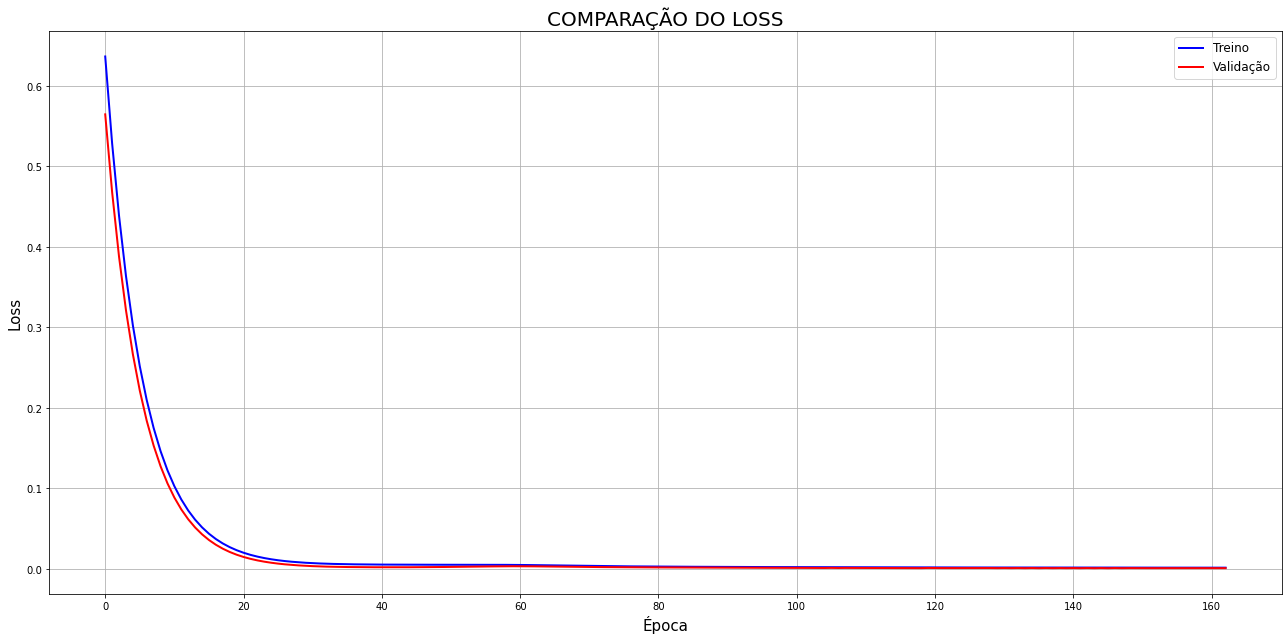

In [19]:
plt.figure(figsize=(18,9))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        
plt.plot(history.history['val_loss'],'-', label = "Validação", linewidth =2, color='red')

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("SEM_INFERENCIA_CONFIRMED_LSTMCNN_Grafico_de_loss.png", dpi=600)
plt.show()

In [20]:
warnings.filterwarnings('ignore')
y_train_pred =  modelo.predict(new_train) 
y_train_pred = normalizador_y.inverse_transform(y_train_pred)
train_y = normalizador_y.inverse_transform(y_train)


y_train_pred = pd.DataFrame(y_train_pred)
train_y = pd.DataFrame(train_y)

train_metrics = get_metrics(train_y, y_train_pred)

In [21]:
warnings.filterwarnings('ignore')
y_test_pred =  modelo.predict(new_test) 
y_test_pred = normalizador_y.inverse_transform(y_test_pred)
test_y = normalizador_y.inverse_transform(y_test)
y_test_pred = pd.DataFrame(y_test_pred)
test_y = pd.DataFrame(test_y)

test_metrics = get_metrics(test_y, y_test_pred)

In [22]:
warnings.filterwarnings('ignore')
y_val_pred =  modelo.predict(new_val) 
y_val_pred = normalizador_y.inverse_transform(y_val_pred)
val_y = normalizador_y.inverse_transform(y_val)
y_val_pred = pd.DataFrame(y_val_pred)
val_y = pd.DataFrame(val_y)

val_metrics = get_metrics(val_y, y_val_pred)

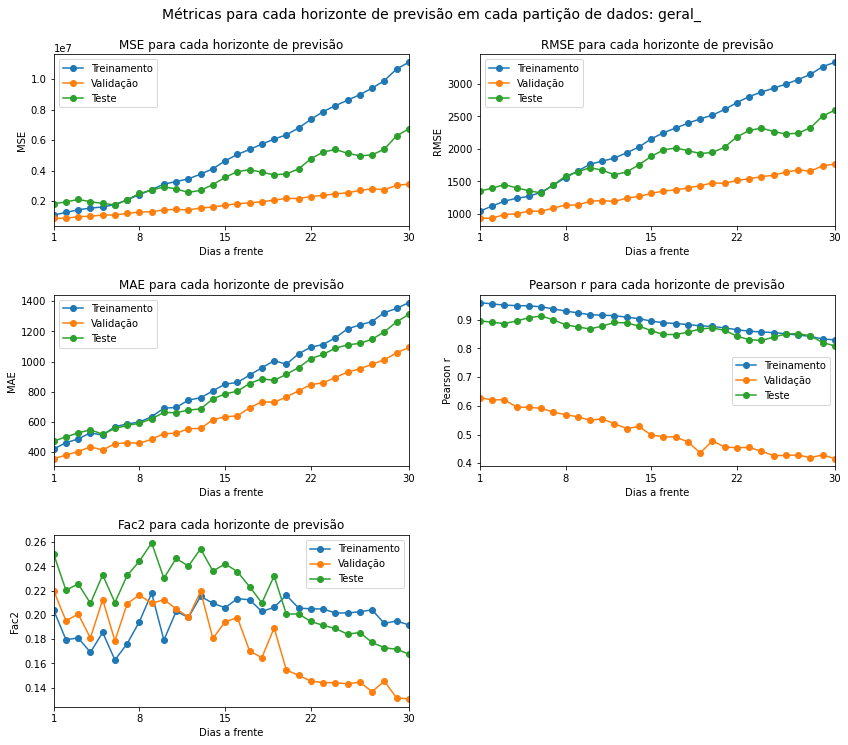

In [23]:
local="geral_"
dict_metrics = {
    'Treinamento': train_metrics,
    'Validação': val_metrics,
    'Teste': test_metrics
}
plot_metrics(
    dict_metrics,
    title='Métricas para cada horizonte de previsão em cada partição de dados: '+local,
    filename="LSTM_REAL"
)

#### K-FOLD

In [24]:
train_data = train_data.append(val_data, ignore_index = True)
train_data = train_data.append(test_data, ignore_index = True)

In [25]:
x_columns = ["Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Confirmed"]

train_x, train_y = generate_regions_dataset("Country/Region", train_data, lookback, lookforward, x_columns, y_columns=y_columns)

In [26]:
normalizador = MinMaxScaler(feature_range=(0, 1))
norm_dados_treino_full = normalizador.fit_transform(train_x)

normalizador_y = MinMaxScaler(feature_range=(0, 1))
y_train = normalizador_y.fit_transform(train_y)

In [27]:
norm_dados_treino_full.shape

(22044, 40)

In [28]:
train_x.head()

,Deaths_t-3,Deaths_t-2,Deaths_t-1,Deaths_t0,Confirmed_t-3,Confirmed_t-2,Confirmed_t-1,Confirmed_t0,C1_t-3,C1_t-2,...,C6_t-1,C6_t0,C7_t-3,C7_t-2,C7_t-1,C7_t0,C8_t-3,C8_t-2,C8_t-1,C8_t0
0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,1,1,1
1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,1,1,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
3,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,1,1,1
4,0,0,0,0,0,0,1,0,1,1,...,0,1,0,0,0,1,1,1,1,1


In [29]:
train_x = train_x.to_numpy(dtype=float)
train_y = train_y.to_numpy(dtype=float)

In [30]:
from sklearn.model_selection import KFold

In [31]:
import warnings
warnings.filterwarnings('ignore')

kfold = KFold(n_splits=5, shuffle=True)
MSEscores = []
RMSEscores = []
MAEscores = []
FACscores = []
Rscores = []

num_k = 0
for train, test in kfold.split(train_x, train_y):
    #Arquitetura da RNA
    normalizador_kfold = MinMaxScaler(feature_range=(0, 1))
    kfold_train = normalizador_kfold.fit_transform(train_x[train])
    
    normalizador_kfold_y = MinMaxScaler(feature_range=(0, 1))
    y_kfold_train = normalizador_kfold_y.fit_transform(train_y[train])
    
    kfold_test = normalizador_kfold.transform(train_x[test])
    y_kfold_test = normalizador_kfold_y.transform(train_y[test])
    
    new_kfold_train = np.empty([kfold_train.shape[0], lookback, len(x_columns)])
    new_kfold_test = np.empty([kfold_test.shape[0],  lookback ,len(x_columns)])

    k = 0
    for i in range(len(x_columns)):
        for j in range(lookback):
            new_kfold_train[:, j, i] = kfold_train[:, k]
            new_kfold_test[:, j, i] = kfold_test[:, k]
            k = k + 1
            
    kfold_train = new_kfold_train
    kfold_test = new_kfold_test
    
    activation = 'relu'
    opt = optimizers.Adamax()
    #opt = optimizers.RMSprop(lr=1e-5)

    tf.random.set_seed(0)

    modelo = Sequential()
    modelo.add(Conv1D(filters=40, kernel_size=2, padding='same', activation= 'tanh',
                      input_shape = (new_kfold_train.shape[1],new_kfold_train.shape[2])))
    #modelo.add(MaxPooling1D(pool_size=5, padding='same'))
    modelo.add(Conv1D(filters=40, kernel_size=2, padding='same', activation= 'tanh'))
    #modelo.add(Conv1D(filters=40, kernel_size=100, padding='same', activation= 'relu'))
    modelo.add(MaxPooling1D(pool_size=2, padding='same'))


    modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)) )
    #modelo.add(LSTM(units = 100, input_shape = (norm_dados_treino_full.shape[1],norm_dados_treino_full.shape[2]), activation='tanh'))
    modelo.add(Dropout(0.1))
    modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh'))
    modelo.add(LSTM(units = 60, activation = 'relu'))
    #modelo.add(Dense(units = 300, input_shape = norm_dados_treino_full.shape, activation = 'relu'))
    #modelo.add(Dense(units = 60, activation = 'relu'))
    #modelo.add(Dense(units = 60, activation = 'tanh'))
    #modelo.add(Dense(units = 60, activation = 'relu'))
    #modelo.add(Dense(units = 300, activation = 'relu'))
    modelo.add(Dense(units = lookforward, activation = 'linear'))

    modelo.compile(optimizer=opt, loss='mse')

    modelo.fit(kfold_train, y_kfold_train, shuffle=False ,batch_size = 1000, epochs = 163, verbose=0)
    
    observado = y_kfold_test
    predicao =  modelo.predict(kfold_test)
    predicao = normalizador_kfold_y.inverse_transform(predicao)
    observado = normalizador_kfold_y.inverse_transform(observado)
    
    metricas_qualidade = get_metrics(pd.DataFrame(observado), pd.DataFrame(predicao), filename="K_FOLD_SEM_INFERENCIA_CONFIRMED_LSTMCNN")
    MSE = metricas_qualidade["MSE"].mean()
    RMSE = metricas_qualidade["RMSE"].mean()
    MAE = metricas_qualidade["MAE"].mean()
    R = metricas_qualidade["Pearson r"].mean()
    FAC2 = metricas_qualidade["Fac2"].mean()
    #print(metricas_qualidade)
    
    print("K: " + str(num_k))
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
    print("R: ", R)
    print("FAC2: ", FAC2)
    print("-----------------------------------")
    MSEscores.append(MSE)
    RMSEscores.append(RMSE)
    MAEscores.append(MAE)
    Rscores.append(R)
    FACscores.append(FAC2)
    num_k = num_k + 1
    
print("RESULTS K-FOLD: ")
print("MSE: " + str(np.mean(MSEscores)) + " +/- " +  str(np.std(MSEscores)))
print("RMSE: " + str(np.mean(RMSEscores)) + " +/- " +  str(np.std(RMSEscores)))
print("MAE: " + str(np.mean(MAEscores)) + " +/- " +  str(np.std(MAEscores)))
print("R: " + str(np.mean(Rscores)) + " +/- " +  str(np.std(Rscores)))
print("FAC2: " + str(np.mean(FACscores)) + " +/- " +  str(np.std(FACscores)))

K: 0
MSE:  2312963.743748204
RMSE:  1466.2969383784352
MAE:  450.77110506348197
R:  0.9139342066472149
FAC2:  0.2166553262266576
-----------------------------------
K: 1
MSE:  2476305.30630069
RMSE:  1510.2051878387479
MAE:  448.19698402122634
R:  0.9195907564652661
FAC2:  0.2458909805700461
-----------------------------------
K: 2
MSE:  2708861.7548875823
RMSE:  1574.4564158271148
MAE:  463.28868600816776
R:  0.8957429399288831
FAC2:  0.22108565812353523
-----------------------------------
K: 3
MSE:  2316304.689813625
RMSE:  1448.7006299129066
MAE:  454.00603529425564
R:  0.9155500283379719
FAC2:  0.21285249867694866
-----------------------------------
K: 4
MSE:  2454022.4952166076
RMSE:  1487.6300100362844
MAE:  455.11776175603495
R:  0.9067524905010208
FAC2:  0.23486085904416218
-----------------------------------
RESULTS K-FOLD: 
MSE: 2453691.5979933417 +/- 144431.84535651145
RMSE: 1497.4578363986977 +/- 43.67179667352242
MAE: 454.27611442863326 +/- 5.1234495527689
R: 0.91031408437

#### TREINAMENTO COM DATASET COMPLETO

In [32]:
normalizador = MinMaxScaler(feature_range=(0, 1))
norm_dados_treino_full = normalizador.fit_transform(train_x)

new_train = np.empty([norm_dados_treino_full.shape[0], lookback, len(x_columns)])

k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_train[:, j, i] = norm_dados_treino_full[:, k]
        k = k + 1
        
normalizador_y = MinMaxScaler(feature_range=(0, 1))
y_train = normalizador_y.fit_transform(train_y)

In [33]:
dump(normalizador, open('Normalizador_Preditores_CONFIRMADOS.pkl', 'wb'))
dump(normalizador_y, open('Normalizador_Target_CONFIRMADOS.pkl', 'wb'))

In [34]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adamax()
#opt = optimizers.RMSprop(lr=1e-5)

tf.random.set_seed(0)

modelo = Sequential()
modelo.add(Conv1D(filters=40, kernel_size=2, padding='same', activation= 'tanh',
                  input_shape = (new_train.shape[1],new_train.shape[2])))
#modelo.add(MaxPooling1D(pool_size=5, padding='same'))
modelo.add(Conv1D(filters=40, kernel_size=2, padding='same', activation= 'tanh'))
#modelo.add(Conv1D(filters=40, kernel_size=100, padding='same', activation= 'relu'))
modelo.add(MaxPooling1D(pool_size=2, padding='same'))


modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)) )
#modelo.add(LSTM(units = 100, input_shape = (norm_dados_treino_full.shape[1],norm_dados_treino_full.shape[2]), activation='tanh'))
modelo.add(Dropout(0.1))
modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh'))
modelo.add(LSTM(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 300, input_shape = norm_dados_treino_full.shape, activation = 'relu'))
#modelo.add(Dense(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 60, activation = 'tanh'))
#modelo.add(Dense(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 300, activation = 'relu'))
modelo.add(Dense(units = lookforward, activation = 'linear'))

modelo.compile(optimizer=opt, loss='mse')

history = modelo.fit(new_train, y_train, shuffle=False ,batch_size = 1000, epochs = 182, verbose=1)

Train on 22044 samples
Epoch 1/182
22044/22044 [==============================] - 6s 270us/sample - loss: 0.5537
Epoch 2/182
22044/22044 [==============================] - 1s 67us/sample - loss: 0.3432
Epoch 3/182
22044/22044 [==============================] - 1s 58us/sample - loss: 0.2137
Epoch 4/182
22044/22044 [==============================] - 2s 69us/sample - loss: 0.1341
Epoch 5/182
22044/22044 [==============================] - 1s 68us/sample - loss: 0.0846
Epoch 6/182
22044/22044 [==============================] - 2s 86us/sample - loss: 0.0537
Epoch 7/182
22044/22044 [==============================] - 1s 61us/sample - loss: 0.0343
Epoch 8/182
22044/22044 [==============================] - 1s 58us/sample - loss: 0.0221
Epoch 9/182
22044/22044 [==============================] - 1s 67us/sample - loss: 0.0145
Epoch 10/182
22044/22044 [==============================] - 1s 65us/sample - loss: 0.0098
Epoch 11/182
22044/22044 [==============================] - 1s 63us/sample - loss: 0.

In [35]:
modelo.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 4, 40)             840       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4, 40)             3240      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 40)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 2, 60)             24240     
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 60)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 2, 60)             29040     
_________________________________________________________________
lstm_20 (LSTM)               (None, 60)               

#### SALVANDO O MODELO

In [36]:
modelo.save('FULL_DATASET_CONFIRMED_Modelo_CNN_LSTM.h5')

#### VERIFICAÇÃO DO LOSS

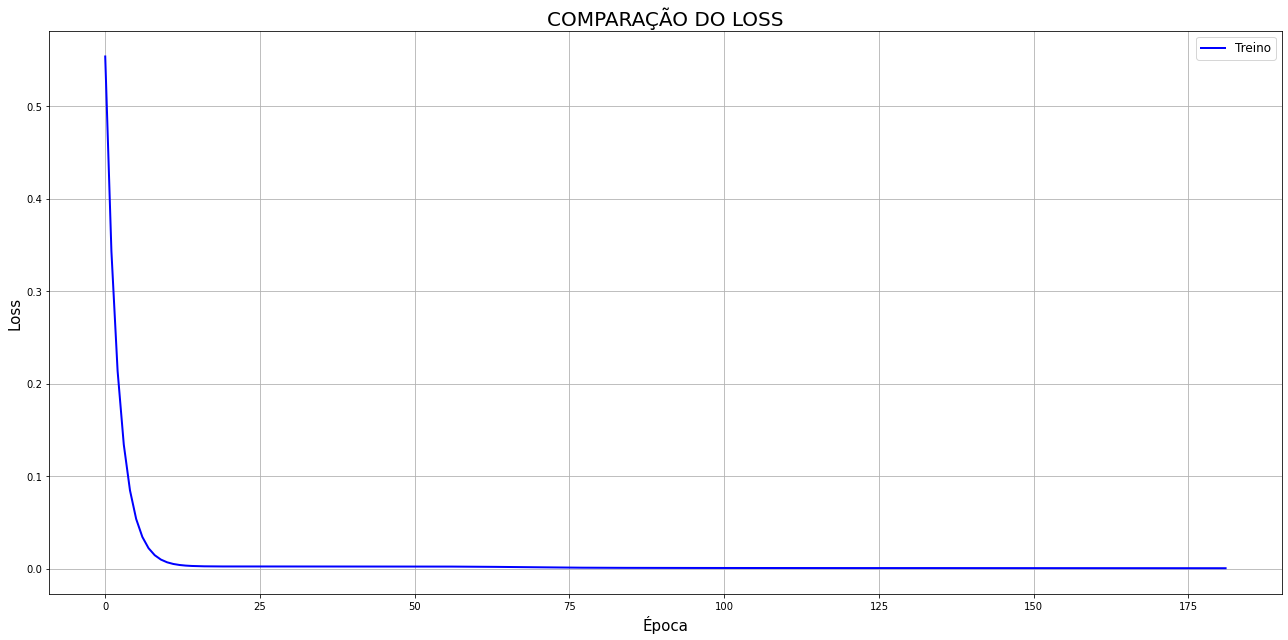

In [37]:
plt.figure(figsize=(18,9))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("SEM_INFERENCIA_CONFIRMED_LSTMCNN_Grafico_de_loss.png", dpi=600)
plt.show()

In [38]:
lb_test = "TRAIN"

if lb_test == "TRAIN":
    observado = y_train
    predicao =  modelo.predict(new_train) 
elif lb_test == "VAL":
    observado = y_val
    predicao =  modelo.predict(new_val) 
elif lb_test == "TEST":
    observado = y_test
    predicao =  modelo.predict(new_test) 

In [39]:
predicao = normalizador_y.inverse_transform(predicao)
observado = normalizador_y.inverse_transform(observado)

In [40]:
df_predicao = pd.DataFrame(predicao)
# df_predicao.to_csv("PREDICTION_TEST_CONFIRMED_LF30")

In [41]:
df_predicao

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,113.195297,130.290573,136.573853,103.294380,123.652481,133.619965,121.454872,146.781723,158.885513,162.240265,...,207.039719,198.741013,242.960785,213.970673,216.398972,245.134842,222.621857,267.803528,269.397034,264.510712
1,192.384384,190.355164,199.524857,166.446716,204.352646,206.450562,215.665222,212.851654,260.348480,199.645996,...,251.156250,262.657349,298.516754,293.324738,290.108734,294.308319,282.310455,329.494537,337.822235,348.142944
2,244.603241,247.307404,256.404175,222.169800,263.924438,274.896484,287.634521,277.921661,330.218872,233.931000,...,291.397583,322.496307,365.675964,356.989105,345.552307,340.100555,336.561401,387.575562,420.904999,403.442932
3,172.696503,174.319901,195.078186,151.252457,176.346588,192.042465,181.415466,197.121506,225.177429,200.012070,...,250.294220,243.500122,282.934692,275.034210,265.214142,299.433624,266.778900,321.562531,328.057343,326.225311
4,17.356165,27.856459,26.772535,62.885902,35.004097,27.561394,55.692017,50.426407,44.593040,68.160904,...,144.440292,176.368225,149.519913,162.373657,172.033997,184.275970,220.184219,176.871368,172.654724,197.752991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22039,1936.039185,1842.018555,1853.214844,1994.017944,1909.175659,1965.031982,1961.502197,1976.142700,1923.092651,2098.964844,...,2304.539307,2281.035889,2156.796631,2307.588135,2338.329590,2327.755127,2330.591553,2245.519287,2331.563232,2394.421631
22040,1515.888672,1448.885620,1460.081177,1569.701172,1503.861328,1535.345215,1543.099976,1553.756226,1522.410034,1665.183350,...,1817.490601,1782.052979,1689.898315,1833.106812,1851.899170,1802.452759,1808.427856,1779.234741,1852.855957,1872.789551
22041,988.223206,956.890564,967.244263,1025.781372,987.811829,1015.614319,1018.836487,1022.015991,1031.808350,1095.822998,...,1201.778687,1180.713379,1136.334351,1233.169434,1229.881104,1175.878174,1189.029175,1213.201050,1265.505371,1250.767700
22042,924.804260,898.589355,905.836487,958.704956,926.011108,953.133362,955.774719,959.072205,972.457886,1030.131348,...,1127.274170,1112.519165,1072.928833,1162.865479,1159.124756,1100.932861,1120.411499,1145.430664,1192.528442,1180.400879


In [42]:
predicao.shape

(22044, 30)

In [43]:
observado.shape

(22044, 30)

#### AVALIAÇÃO DO MODELO POR HORIZONTE DE PREDIÇÃO

In [44]:
metricas_qualidade = get_metrics(pd.DataFrame(observado), pd.DataFrame(predicao), filename=lb_test + "SEM_INFERENCIA_CONFIRMED_LSTMCNN")
metricas_qualidade

,MSE,RMSE,MAE,Pearson r,Fac2
0,649954,806.197,286.52,0.960364,0.278398
1,731871,855.495,302.091,0.956363,0.27808
2,786049,886.594,311.524,0.954492,0.275767
3,780845,883.654,301.343,0.95622,0.285066
4,760678,872.168,319.608,0.958852,0.280394
5,797698,893.139,335.683,0.958342,0.276311
6,982156,991.038,359.209,0.949762,0.274859
7,1.20167e+06,1096.21,379.184,0.939651,0.27368
8,1.3978e+06,1182.29,415.381,0.932077,0.261885
9,1.50417e+06,1226.45,398.676,0.928406,0.27495


#### BRASIL

In [45]:
brazil = train_data[train_data['Country/Region'] == 'Brazil'].copy()
x_brazil, y_brazil = generate_regions_dataset(
    key="Country/Region",
    regions_data=brazil,
    look_back=lookback,
    look_forward=lookforward,
    x_columns=x_columns,
    y_columns=y_columns
)

In [46]:
local="Brasil_"
x_brazil_scaled = normalizador.transform(x_brazil)
y_brazil_scaled = normalizador_y.transform(y_brazil)

new_brazil = np.empty([x_brazil_scaled.shape[0], lookback, len(x_columns)])

k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_brazil[:, j, i] = x_brazil_scaled[:, k]
        k = k + 1

y_brazil_pred = modelo.predict(new_brazil)
y_brazil_pred = normalizador_y.inverse_transform(y_brazil_pred)

y_brazil = normalizador_y.inverse_transform(y_brazil_scaled)

y_brazil_pred = pd.DataFrame(y_brazil_pred)
y_brazil = pd.DataFrame(y_brazil)

brazil_metrics = get_metrics(y_brazil, y_brazil_pred)
brazil_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,3.9372e+07,6274.71,3883.05,0.908609,0.834586
1,4.37353e+07,6613.27,4191.17,0.896852,0.834586
2,4.3663e+07,6607.8,4120.28,0.896252,0.796992
3,3.69023e+07,6074.73,3670.32,0.915406,0.827068
4,2.73773e+07,5232.34,3178.29,0.939509,0.819549
5,2.47368e+07,4973.61,3171.74,0.947682,0.834586
6,3.3434e+07,5782.21,3846.84,0.92829,0.819549
7,4.56453e+07,6756.13,4575.93,0.900602,0.796992
8,5.41267e+07,7357.08,4959.33,0.881679,0.736842
9,5.49634e+07,7413.73,4944.03,0.879379,0.699248


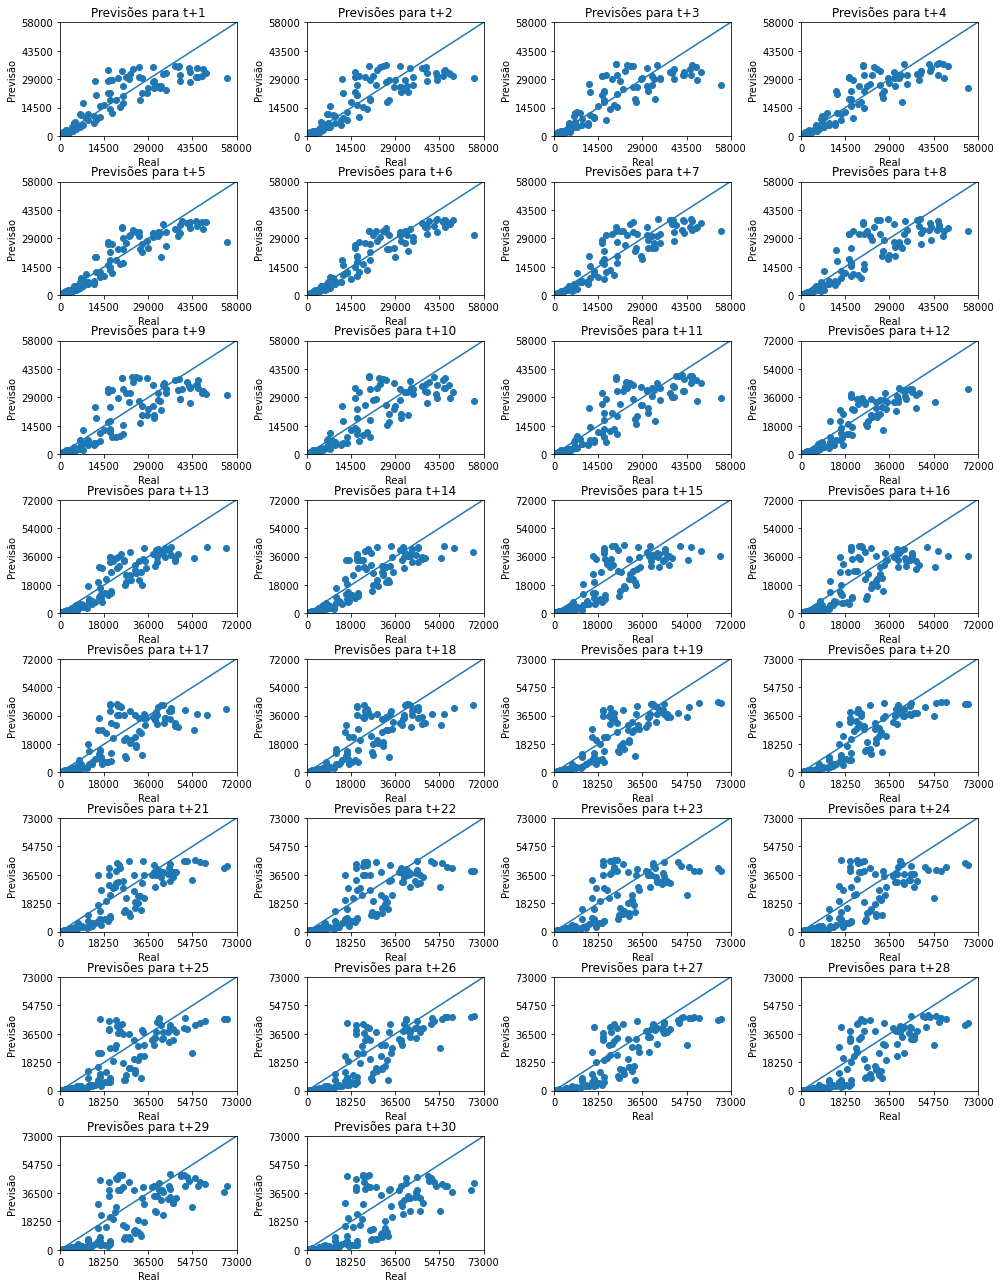

In [47]:
plot_scatter(
    y_brazil,
    y_brazil_pred,
    )

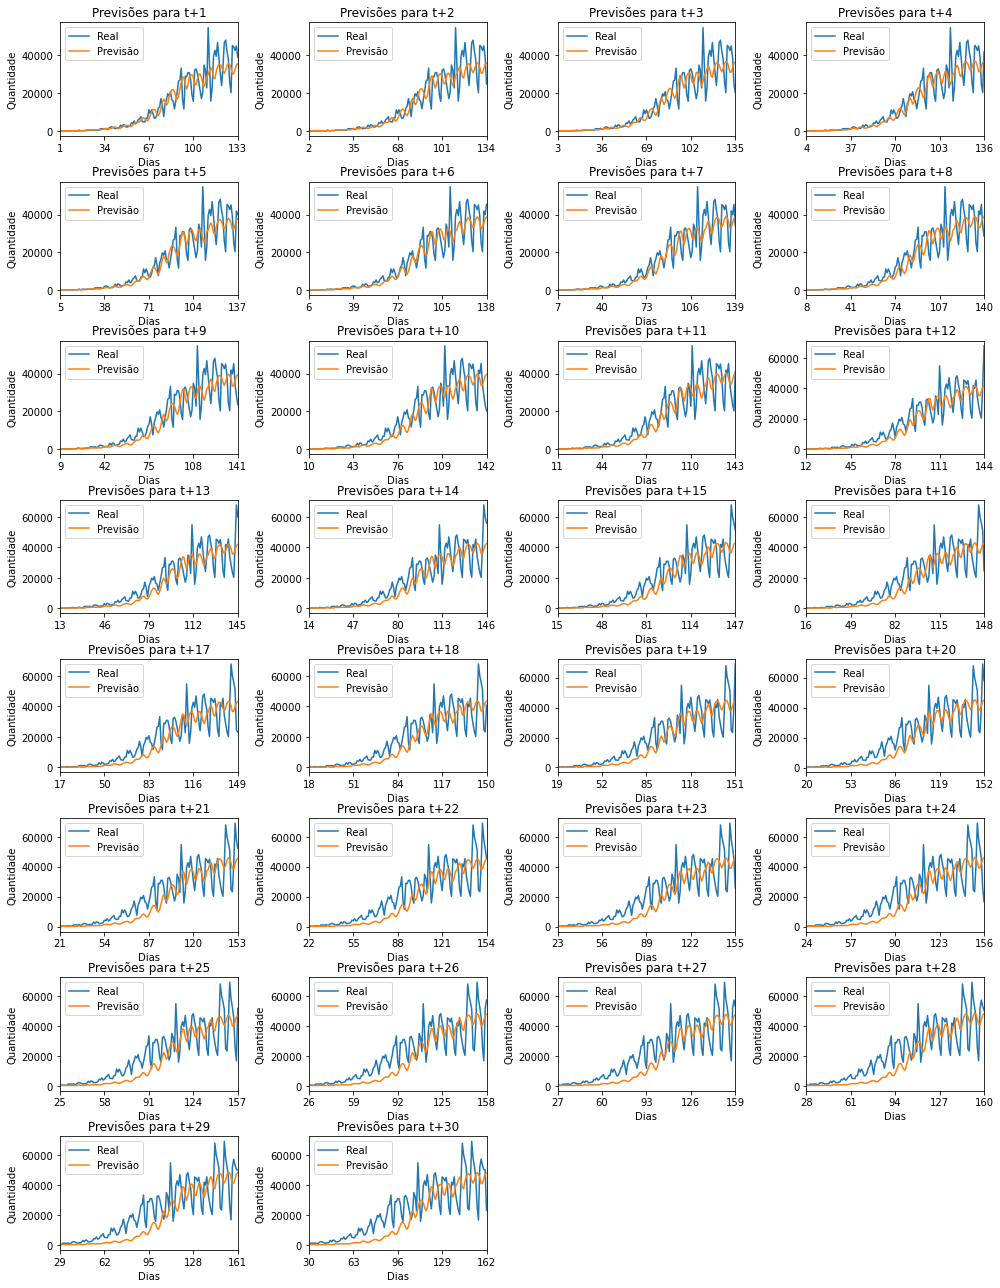

In [48]:
plot_samples(
    y_brazil,
    y_brazil_pred,
   
    xlabel='Dias',
    ylabel='Quantidade'
)

#### BAHIA

In [49]:
bahia = train_data[train_data['Country/Region'] == 'BA'].copy()
x_bahia, y_bahia = generate_regions_dataset(
    key="Country/Region",
    regions_data=bahia,
    look_back=lookback,
    look_forward=lookforward,
    x_columns=x_columns,
    y_columns=y_columns
)

In [50]:
local="Bahia_"
x_bahia_scaled = normalizador.transform(x_bahia)
y_bahia_scaled = normalizador_y.transform(y_bahia)

new_bahia = np.empty([x_bahia_scaled.shape[0], lookback, len(x_columns)])

k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_bahia[:, j, i] = x_bahia_scaled[:, k]
        k = k + 1

y_bahia_pred = modelo.predict(new_bahia)
y_bahia_pred = normalizador_y.inverse_transform(y_bahia_pred)

y_bahia = normalizador_y.inverse_transform(y_bahia_scaled)

y_bahia_pred = pd.DataFrame(y_bahia_pred)
y_bahia = pd.DataFrame(y_bahia)

bahia_metrics = get_metrics(y_bahia, y_bahia_pred)
bahia_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,871983,933.801,588.784,0.690541,0.367188
1,845502,919.512,597.066,0.699776,0.34375
2,889772,943.277,600.165,0.682869,0.390625
3,974533,987.184,602.974,0.661426,0.382812
4,932491,965.656,590.087,0.669241,0.390625
5,977633,988.753,617.487,0.653812,0.398438
6,1.10857e+06,1052.89,656.195,0.610973,0.40625
7,1.31208e+06,1145.46,722.665,0.580775,0.367188
8,1.33007e+06,1153.29,749.293,0.592542,0.398438
9,1.32947e+06,1153.03,758.945,0.617054,0.382812


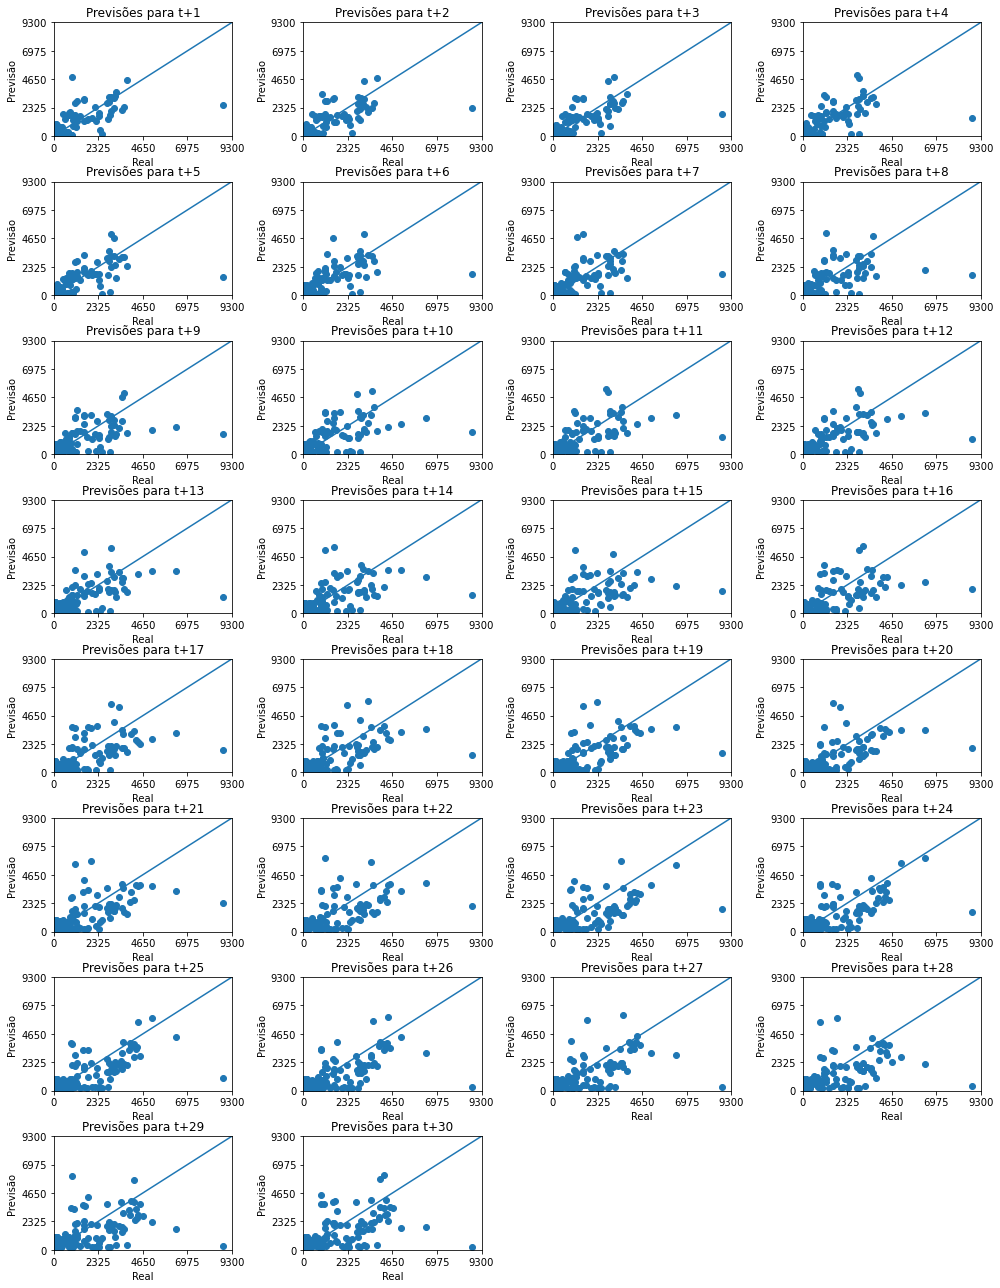

In [51]:
plot_scatter(
    y_bahia,
    y_bahia_pred,  
)

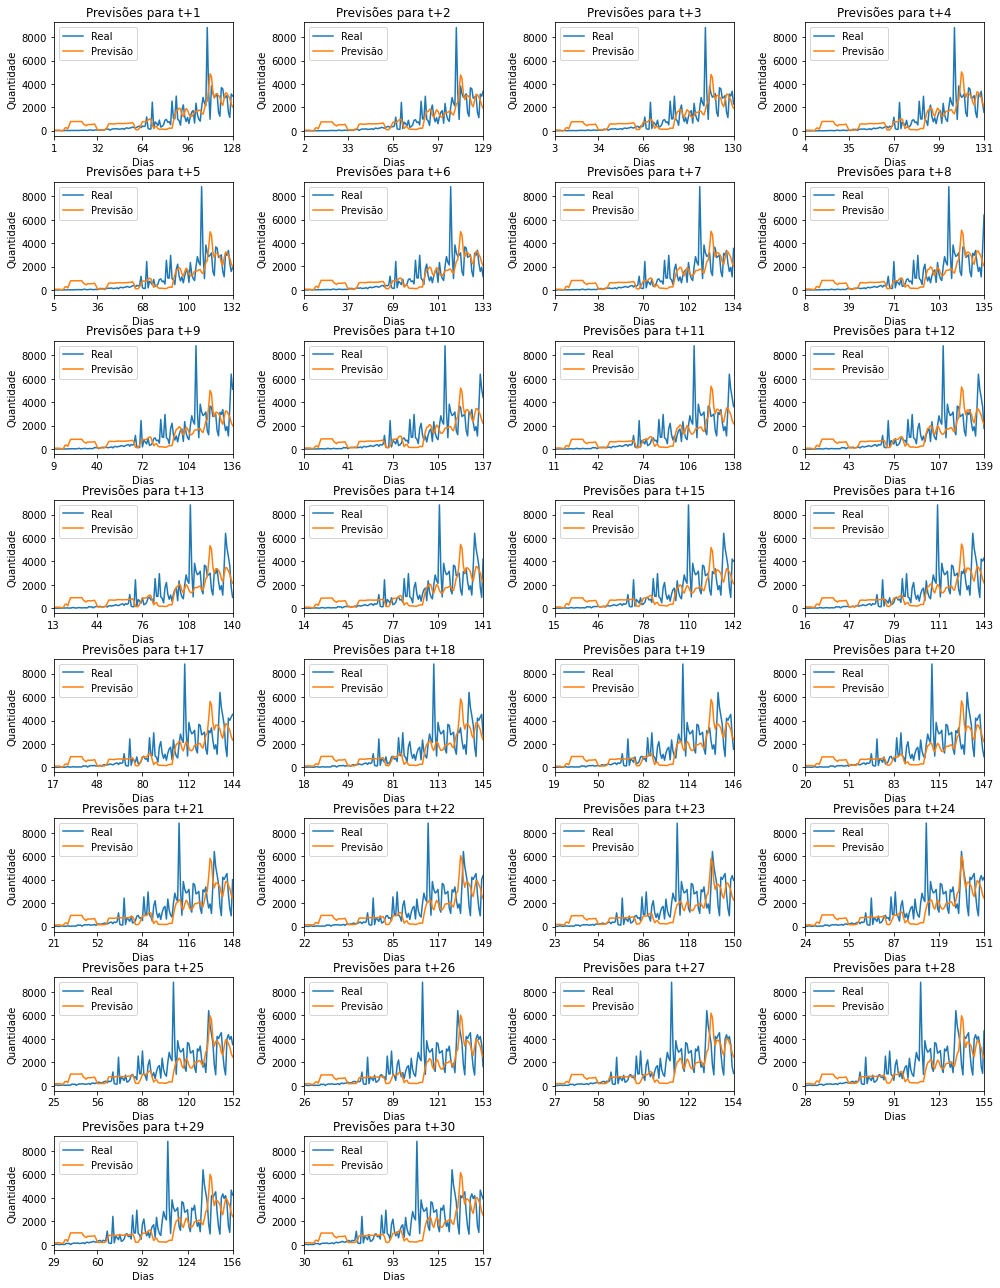

In [52]:
plot_samples(
    y_bahia,
    y_bahia_pred,
    
    xlabel='Dias',
    ylabel='Quantidade'
)